# 🌐 Cyberattack Detection and Anomalous Behavior Analysis Using Recurrent Neural Networks (RNN)

## Introduction
Cybersecurity has become a critical domain as network attacks increasingly threaten systems worldwide. Detecting cyberattacks and analyzing anomalous behaviors in network traffic is essential for securing digital environments. Here, I focused on utilizing Recurrent Neural Networks (RNNs) to identify abnormal patterns in network traffic that indicate cyberattacks, including attacks like DDoS, port scanning, etc.

## Dataset
For this project, the [Intrusion detection evaluation dataset (CIC-IDS2017)](https://www.unb.ca/cic/datasets/ids-2017.html) from the [Canadian Institute for Cybersecurity](https://www.unb.ca) is utilized. This dataset is widely recognized for evaluating intrusion detection systems and encompasses a diverse set of network traffic scenarios.

The dataset contains real-world attack simulations such as DDoS, brute force, SQL injection, port scanning, and botnet activities. These scenarios reflect actual attack behaviors, making the dataset highly practical for cybersecurity research.

The sequential nature of network traffic in this dataset makes it suitable for RNN-based methods. The features can be structured as time-series sequences to capture temporal dependencies critical for detecting anomalies.

Since `Kaggle API` offers an efficient way to access datasets, I used the [Network Intrusion dataset (CIC-IDS2017)](https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset) hosted on `Kaggle`. However, you can download it manually.

Install the `Kaggle` package if you haven’t already:

In [1]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


Download the dataset by running:

In [2]:
import os
import subprocess

# Define the dataset name and destination path
dataset = 'chethuhn/network-intrusion-dataset'
destination_path = '/tmp/network-intrusion-dataset'

# Check if the dataset already exists
if not os.path.exists(destination_path):
    print(f"Dataset not found at {destination_path}\nDownloading...")
    os.makedirs(destination_path, exist_ok=True)  # Ensure the destination directory exists
    
    # Keep trying to download until it succeeds, in case of network connection issues.
    while True:
        try:
            subprocess.run(f"kaggle datasets download -d {dataset} -p {destination_path} --unzip", 
                           shell=True, 
                           check=True,
                           stderr=subprocess.STDOUT)
            print("Download complete.")
            break  # Exit the loop when download succeeds
        except subprocess.CalledProcessError:
            print(f"Download failed.\nRetrying...")
else:
    print(f"Dataset already exists at {destination_path}\nSkipping download.")

Dataset not found at /tmp/network-intrusion-dataset
Downloading...
Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset
License(s): CC0-1.0
100%|██████████| 230M/230M [01:02<00:00, 2.64MB/s] 
100%|██████████| 230M/230M [01:02<00:00, 3.58MB/s]
Download complete.


## Preprocessing the Data
With the dataset downloaded, the next step is to preprocess it. Data preprocessing ensures that the data is clean and ready for modeling. Here are the main steps involved:

### Load the Data: 
Simply use `pandas` to load the dataset and inspect it. Also, Python's `glob` module dynamically finds all CSV files in the destination folder.

In [3]:
import pandas as pd
import glob

# Get all CSV files in the specified directory
csv_files = glob.glob(os.path.join(destination_path, "*.csv"))

# Order for the days of the week based on the dataset documentation
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Sort the files based on day and time of day (morning before afternoon)
csv_files_sorted = sorted(csv_files, key=lambda x: (
    days_order.index(next(day for day in days_order if day in os.path.basename(x))),
    'Afternoon' in os.path.basename(x)
))

# Combine all CSVs into one DataFrame in the sorted order
df = pd.concat([pd.read_csv(file) for file in csv_files_sorted], ignore_index=True)

print("Data loaded successfully.\nShape:", df.shape)
print("Data Columns:", df.columns.tolist())

Data loaded successfully.
Shape: (2830743, 79)
Data Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST F

Inspect the loaded data.

In [4]:
df.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,443,32046067,2,0,74,0,37,37,37.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
946912,53,66073,4,4,176,428,44,44,44.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2216843,53,60025,1,1,56,112,56,56,56.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
699389,53,47619,1,1,44,213,44,44,44.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1170268,80,99329635,6,7,320,11595,302,0,53.333333,121.856746,...,20,13973.0,0.0,13973,13973,99300000.0,0.0,99300000,99300000,DoS Hulk
800686,443,305034,22,45,871,63051,389,0,39.590909,99.163482,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1434488,58409,18702,2,1,280,6,274,6,140.000000,189.504617,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1968368,8088,48,2,0,4,0,2,2,2.000000,0.000000,...,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
934343,53,39727,4,2,120,248,30,30,30.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
693547,53911,1004472,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Clean the Data:
- Remove duplicates.
- Clean column names.
- Handle missing and infinite values.

#### Median imputation is used because:
- It is **robust to outliers**, ensuring extreme values don't affect the imputed result.
- It helps **maintain distribution** by filling missing values with a representative value.

In [5]:
import numpy as np

# Check for missing values
print(f"Total missing values in the DataFrame: {df.isnull().sum().sum()}\n")
print(f"Number of missing values in the first 20 columns:\n{df.isnull().sum().head(20)}\n")

# Remove spaces at the beginning and at the end of the column names
df.columns = df.columns.str.strip()

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Use median imputation
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
    
# Check for missing values after cleaning
print(f"Total missing values after cleaning: {df.isnull().sum().sum()}\n")

print("Data Columns:", df.columns.tolist())

Total missing values in the DataFrame: 1358

Number of missing values in the first 20 columns:
 Destination Port                  0
 Flow Duration                     0
 Total Fwd Packets                 0
 Total Backward Packets            0
Total Length of Fwd Packets        0
 Total Length of Bwd Packets       0
 Fwd Packet Length Max             0
 Fwd Packet Length Min             0
 Fwd Packet Length Mean            0
 Fwd Packet Length Std             0
Bwd Packet Length Max              0
 Bwd Packet Length Min             0
 Bwd Packet Length Mean            0
 Bwd Packet Length Std             0
Flow Bytes/s                    1358
 Flow Packets/s                    0
 Flow IAT Mean                     0
 Flow IAT Std                      0
 Flow IAT Max                      0
 Flow IAT Min                      0
dtype: int64

Total missing values after cleaning: 0

Data Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Lengt

### Relabeling:

Total count of all attack categories in the `Label` column.

In [6]:
print(df['Label'].value_counts().sum)

<bound method Series.sum of Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64>


#### Mapping and relabeling the attack types: 
`BENIGN` is labeled as `0` (indicating no attack), and all other attack types are labeled as `1` (indicating an attack).

In [7]:
df['Label'] = np.where(df['Label'].isin(['BENIGN']), 0, 1)

Total count of all relabeled attack categories.

In [8]:
print(df['Label'].value_counts())

Label
0    2273097
1     557646
Name: count, dtype: int64


Visualizing the Distribution of Labels with a Count Plot.

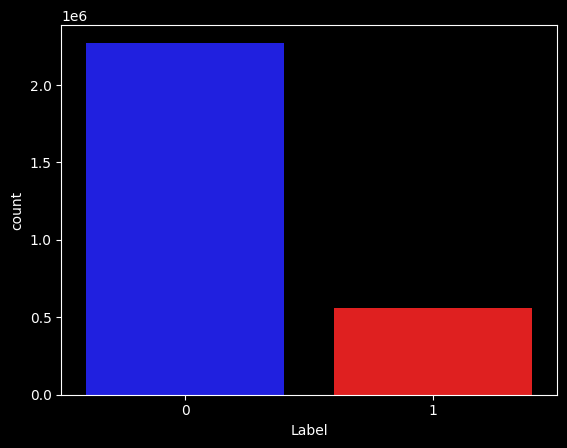

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style to dark background with light text and lines
plt.style.use('dark_background')

sns.countplot(x='Label', data=df, palette=['b', 'r'], hue='Label', legend=False)

plt.show()

### Separating features and target:

In [10]:
X = df.drop('Label', axis=1)
y = df['Label']

Inspect sample features.

In [11]:
X.sample(5, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
746827,443,32046067,2,0,74,0,37,37,37.000000,0.000000,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0
946912,53,66073,4,4,176,428,44,44,44.000000,0.000000,...,3,20,0.0,0.0,0,0,0.0,0.0,0,0
2216843,53,60025,1,1,56,112,56,56,56.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
699389,53,47619,1,1,44,213,44,44,44.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
1170268,80,99329635,6,7,320,11595,302,0,53.333333,121.856746,...,3,20,13973.0,0.0,13973,13973,99300000.0,0.0,99300000,99300000


Inspect sample targets.

In [12]:
y.sample(5, random_state=42)

746827     0
946912     0
2216843    0
699389     0
1170268    1
Name: Label, dtype: int64

### Splitting the dataset into training and testing sets:

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Normalizing data:

In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, and transform the test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Applying PCA for dimensionality reduction:

In [15]:
from sklearn.decomposition import PCA

# Define the desired explained variance threshold (e.g., 95%)
explained_variance_threshold = 0.95

# Fit PCA without specifying the number of components to compute all components
pca = PCA()
pca.fit(X_train)

# Calculate the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find the number of components that meet the threshold
n_components_best = (cumulative_variance >= explained_variance_threshold).argmax() + 1

print(f"Original features count: {X_train.shape[1]}")

# Apply PCA with the optimal number of components
pca = PCA(n_components=n_components_best)
X_train = pca.fit_transform(X_train)

# Transform the test data using the same PCA model
X_test = pca.transform(X_test)

print(f"Reduced features count: {X_train.shape[1]}")

Original features count: 78
Reduced features count: 25


### Plotting the cumulative explained variance:

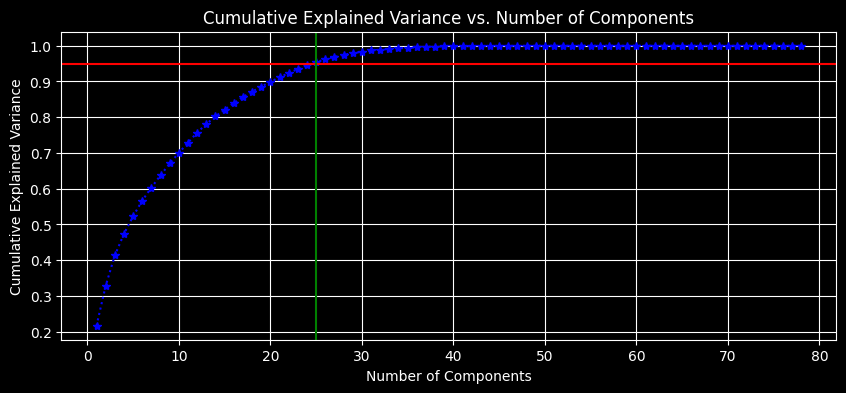

In [16]:
import matplotlib.pyplot as plt

# Set the style to dark background with light text and lines
plt.style.use('dark_background')

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='b', marker='*', linestyle='dotted')
plt.axhline(y=explained_variance_threshold, color='r', linestyle='-')
plt.axvline(x=n_components_best, color='g', linestyle='-')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


### Creating Sequential Data for Time Series Classification:

In [17]:
def create_sequences(X, y, sequence_length):
    sequences_X = [X[i:i + sequence_length] for i in range(0, len(X) - sequence_length + 1, sequence_length)]
    # The corresponding labels for each sequence (using the last label in the sequence)
    sequences_y = [y.iloc[i + sequence_length - 1] for i in range(0, len(X) - sequence_length + 1, sequence_length)]
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 100

# Create sequential data for training and testing
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

print("\nData shapes after processing:")
print(f"X_train_seq shape: {X_train_seq.shape}\nX_test_seq shape: {X_test_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}\ny_test_seq shape: {y_test_seq.shape}")


Data shapes after processing:
X_train_seq shape: (19815, 100, 25)
X_test_seq shape: (8492, 100, 25)
y_train_seq shape: (19815,)
y_test_seq shape: (8492,)


### Model Training:

#### The model architecture consists of:
- **Two Bidirectional LSTM layers**:
  - 128 units for the first layer with `return_sequences=True`.
  - 64 units for the second layer with `return_sequences=False`.
- **Dropout Layer**: Helps prevent overfitting by randomly deactivating neurons.
- **Dense Layers**:
  - First dense layer with 64 units and `LeakyReLU` activation for flexible learning of non-linear patterns.
  - Output dense layer with 1 unit and `sigmoid` activation for binary classification.
- **Optimizer Search**: Either `adam` or `rmsprop` is used as optimizers.

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
import keras_tuner as kt
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))))
        model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh')))
        model.add(Dropout(0.2)) # Dropout layer for regularization
        model.add(Dense(64, activation='LeakyReLU'))
        model.add(Dense(1, activation='sigmoid')) # Single output for binary classification
        
        model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                      loss='binary_crossentropy', metrics=['accuracy'])
        return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(LSTMHyperModel(), objective='val_accuracy', max_trials=5, executions_per_trial=2)

# Implement EarlyStopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train_seq, y_train_seq, epochs=10, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models()[0]

# Train the best model
history = best_model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs= 30, batch_size=32, callbacks=[early_stopping])

Trial 2 Complete [00h 17m 44s]
val_accuracy: 0.9516015350818634

Best val_accuracy So Far: 0.9560762941837311
Total elapsed time: 00h 41m 02s
Epoch 1/30
620/620 [==============================] - 74s 115ms/step - loss: 0.0658 - accuracy: 0.9713 - val_loss: 0.1203 - val_accuracy: 0.9500
Epoch 2/30
620/620 [==============================] - 73s 117ms/step - loss: 0.0552 - accuracy: 0.9764 - val_loss: 0.1266 - val_accuracy: 0.9512
Epoch 3/30
620/620 [==============================] - 75s 121ms/step - loss: 0.0451 - accuracy: 0.9824 - val_loss: 0.1442 - val_accuracy: 0.9498
Epoch 4/30
620/620 [==============================] - 76s 122ms/step - loss: 0.0329 - accuracy: 0.9871 - val_loss: 0.1772 - val_accuracy: 0.9512


### Model Evaluation:

Predict probabilities.

In [19]:
from sklearn.preprocessing import Binarizer

# Initialize the Binarizer with a custom threshold (default is 0.0)
binarizer = Binarizer(threshold=0.5)

y_pred_prob = best_model.predict(X_test_seq)

# Apply binarizer to the 
y_pred = binarizer.fit_transform(y_pred_prob.reshape(-1, 1)).flatten()

266/266 [==============================] - 10s 36ms/step


#### Calculate Evaluation Metrics:

The evaluation results show that the model performs well on the test set.

- The model achieved an excellent test **accuracy**, matching the validation accuracy. This consistency indicates robustness across unseen data.

- The **Recall** for class 1 (positive) is high, meaning the model correctly identifies positive cases most of the time. This is critical in scenarios where false negatives are costly.
 
- The **F1-Score** shows a good balance between precision and recall for this class.

- The **ROC-AUC** score indicates excellent separability between the positive and negative classes. This highlights the strong discriminatory power of the model.


In [20]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test_seq, y_pred)
print(f"Accuracy: {accuracy:.4f}")

recall = recall_score(y_test_seq, y_pred)
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test_seq, y_pred)
print(f"F1 Score: {f1:.4f}")

roc_auc = roc_auc_score(y_test_seq, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.9500
Recall: 0.8718
F1 Score: 0.8705
ROC-AUC Score: 0.9877


#### **Classification Report**:

In [21]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_seq, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6854
           1       0.87      0.87      0.87      1638

    accuracy                           0.95      8492
   macro avg       0.92      0.92      0.92      8492
weighted avg       0.95      0.95      0.95      8492



Class imbalance is present: 6854 negative cases vs. 1638 positive cases. Despite this, the model maintains good performance on both classes.


#### **ROC Curve**: 

The ROC curve illustrates the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate):
- **Shape**: The curve is close to the top-left corner, indicating high sensitivity and specificity.
- **AUC**: Based on this, the model's predictions are highly reliable.



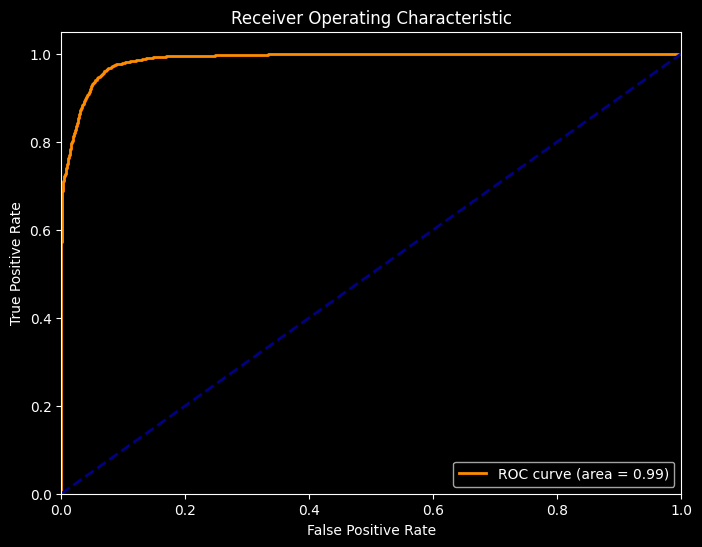

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Compute the **confusion matrix**:

The **confusion matrix** provides a breakdown of predictions:
- **True Negatives (TN)**: The majority class predictions are highly accurate.
- **False Negatives (FN)**: Class 1 has more missed predictions, as reflected by the recall percentage.
- **Visualization**: The heatmap confirms effective separation of classes, though there are some errors in the minority class.

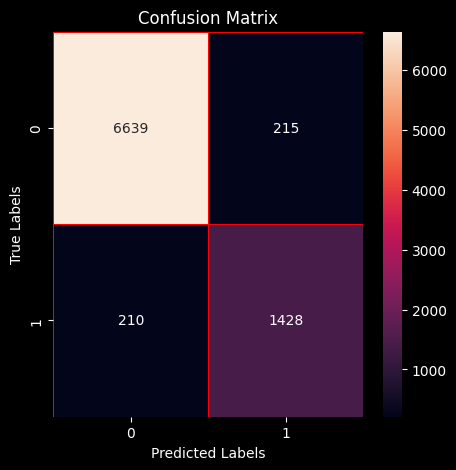

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_seq, y_pred)
f, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(cm, annot=True, fmt='.0f', linewidths=0.5, linecolor="r", ax=ax)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Error Analysis:

#### Possible Sources of Error:
1. **Class Imbalance**:
   - The dataset has significantly more negative samples than positive ones (6854 vs. 1638). While the model performs well, metrics like recall and precision for class 1 are slightly affected.
2. **Overfitting**:
   - The increasing validation loss in later epochs indicates mild overfitting. Techniques like **Dropout** and **EarlyStopping** were effective, for example, **EarlyStopping** halted training after the validation loss increased for 3 consecutive epochs, mitigating further overfitting. However, further strategies like **class weighting** or additional data augmentation could improve performance.

### Final Note
The model demonstrates excellent performance with excellent **accurac**y and a high **ROC-AUC score**, indicating reliability in separating the two classes. While **recall** and **F1-score** for the minority class (87.18%) are slightly lower, the overall results are impressive. 